# Extra Boosting MSE dataset — ExtraBoost demo

Trains the Go ExtraBoost model via the Python bridge using the pre-generated static features. Static features: f₁–f₃, extra features: e₁–e₄, target: y. Train/test split is defined by the time coordinate (t < 0.5 → train).

In [10]:
import pandas as pd

In [11]:
from pathlib import Path
import sys


NB_DIR = Path.cwd().resolve()
REPO_ROOT = NB_DIR.parent.parent
PYTHON_PATH = REPO_ROOT / 'python'
if str(PYTHON_PATH) not in sys.path:
    sys.path.insert(0, str(PYTHON_PATH))
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
pd.set_option('display.max_rows', None)

from extra_boost_py import BoosterParams, ExtraBooster
from extra_boost_py.go_lib import build_shared

DATA_PATH = Path('../../datasets/mse/extra_boosting_static_features_k50.csv')
if not DATA_PATH.exists():
    raise FileNotFoundError(f'Dataset not found at {DATA_PATH}')

df = pd.read_csv(DATA_PATH)
df.head()

,f_1,f_2,f_3,e_1,e_2,e_3,e_4,t,y
0,0,0,0,1.0,0.000000,0.000000,1.000000,0.000000,0.120065
1,0,0,0,1.0,0.004567,0.004567,0.999990,0.004567,0.099342
2,0,0,0,1.0,0.013218,0.013218,0.999913,0.013218,0.065454
3,0,0,0,1.0,0.049984,0.049964,0.998751,0.049984,0.084479
4,0,0,0,1.0,0.145083,0.144575,0.989494,0.145083,0.047087


In [12]:
pd.set_option("display.max_rows", None)        # show all rows
pd.set_option("display.max_columns", None)     # show all columns
pd.set_option("display.max_colwidth", None)    # show full cell contents
pd.set_option("display.width", 0)              # auto-detect width
pd.set_option("display.expand_frame_repr", False)  # don't wrap DataFrame across lines

In [13]:
print(df)

     f_1  f_2  f_3  e_1       e_2       e_3       e_4         t         y
0      0    0    0  1.0  0.000000  0.000000  1.000000  0.000000  0.120065
1      0    0    0  1.0  0.004567  0.004567  0.999990  0.004567  0.099342
2      0    0    0  1.0  0.013218  0.013218  0.999913  0.013218  0.065454
3      0    0    0  1.0  0.049984  0.049964  0.998751  0.049984  0.084479
4      0    0    0  1.0  0.145083  0.144575  0.989494  0.145083  0.047087
5      0    0    0  1.0  0.184334  0.183292  0.983059  0.184334  0.121520
6      0    0    0  1.0  0.189413  0.188283  0.982115  0.189413  0.145090
7      0    0    0  1.0  0.194358  0.193136  0.981172  0.194358  0.167087
8      0    0    0  1.0  0.198291  0.196994  0.980405  0.198291  0.183013
9      0    0    0  1.0  0.201457  0.200097  0.979776  0.201457  0.194360
10     0    0    0  1.0  0.205738  0.204290  0.978910  0.205738  0.207070
11     0    0    0  1.0  0.208666  0.207155  0.978308  0.208666  0.213748
12     0    0    0  1.0  0.280242  0.2

In [14]:
df.describe()

,f_1,f_2,f_3,e_1,e_2,e_3,e_4,t,y
count,248.000000,248.000000,248.000000,248.0,248.000000,248.000000,248.000000,248.000000,248.000000
mean,0.354839,0.407258,0.471774,1.0,0.522252,0.483134,0.839021,0.522252,0.151445
std,0.479432,0.492317,0.500212,0.0,0.254254,0.217064,0.125547,0.254254,0.075823
min,0.000000,0.000000,0.000000,1.0,0.000000,0.000000,0.540302,0.000000,-0.002028
25%,0.000000,0.000000,0.000000,1.0,0.359188,0.351514,0.747666,0.359188,0.091071
50%,0.000000,0.000000,0.000000,1.0,0.523444,0.499581,0.865608,0.523444,0.149314
75%,1.000000,1.000000,1.000000,1.0,0.726256,0.664075,0.936183,0.726256,0.218852
max,1.000000,1.000000,1.000000,1.0,1.000000,0.841471,1.000000,1.000000,0.287058


In [15]:
features_inter_cols = ['f_1', 'f_2', 'f_3']
features_extra_cols = ['e_1', 'e_2', 'e_3', 'e_4']
target_col = 'y'
time_col = 't'

def contiguous(array):
    return np.ascontiguousarray(array, dtype=np.float64)

mask_train = df[time_col] < 0.5
mask_test = ~mask_train

train_features_inter = contiguous(df.loc[mask_train, features_inter_cols].to_numpy())
train_features_extra = contiguous(df.loc[mask_train, features_extra_cols].to_numpy())
train_target = contiguous(df.loc[mask_train, target_col].to_numpy())

test_features_inter = contiguous(df.loc[mask_test, features_inter_cols].to_numpy())
test_features_extra = contiguous(df.loc[mask_test, features_extra_cols].to_numpy())
test_target = contiguous(df.loc[mask_test, target_col].to_numpy())

train_features_inter.shape, test_features_inter.shape

((124, 3), (124, 3))

In [16]:
build_shared()
params = BoosterParams(n_stages=200, learning_rate=0.2, max_depth=6, loss='mse')
booster = ExtraBooster.train(
    train_features_inter,
    train_features_extra,
    train_target,
    params=params,
)

train_predictions = booster.predict(train_features_inter, train_features_extra)
test_predictions = booster.predict(test_features_inter, test_features_extra)

def rmse(y_true, y_pred):
    diff = y_true - y_pred
    return float(np.sqrt(np.mean(diff * diff)))

rmse_train = rmse(train_target, train_predictions)
rmse_test = rmse(test_target, test_predictions)
print(f'Train RMSE: {rmse_train:.6f}')
print(f'Test RMSE: {rmse_test:.6f}')

Train RMSE: 0.035665
Test RMSE: 1.609488


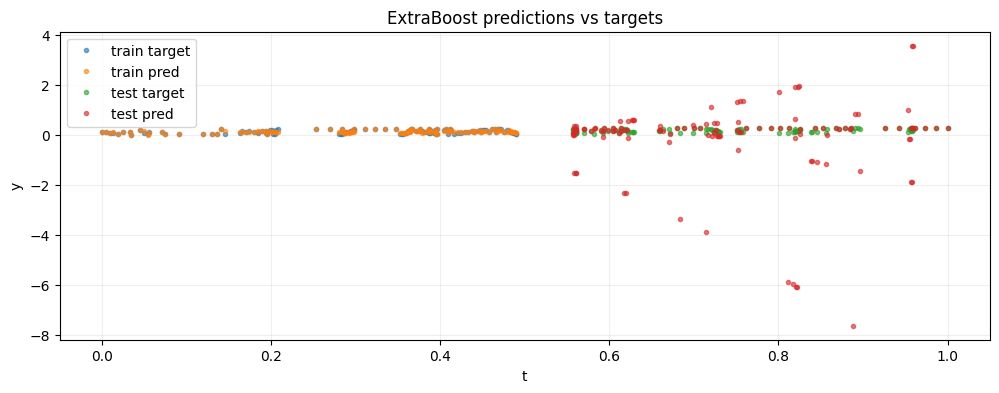

In [17]:
plt.figure(figsize=(12, 4))
plt.plot(df.loc[mask_train, time_col], train_target, '.', label='train target', alpha=0.6)
plt.plot(df.loc[mask_train, time_col], train_predictions, '.', label='train pred', alpha=0.6)
plt.plot(df.loc[mask_test, time_col], test_target, '.', label='test target', alpha=0.6)
plt.plot(df.loc[mask_test, time_col], test_predictions, '.', label='test pred', alpha=0.6)
plt.xlabel('t')
plt.ylabel('y')
plt.title('ExtraBoost predictions vs targets')
plt.legend()
plt.grid(True, alpha=0.2)
plt.show()

booster.close()